In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Bigger font
sns.set(font_scale=1.3)
plt.style.use('fivethirtyeight')
# Figure size®
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 2.5
rcParams['lines.marker'] = '.'
rcParams['lines.linewidth'] = 1
rcParams['lines.markersize'] = 5
rcParams['legend.fontsize'] = 10
rcParams['axes.titlesize'] = 16
# plt.rc('figure.subplot', wspace=.33)
# Slides
from notebook.services.config import ConfigManager
cm = ConfigManager()
# cm.update('livereveal', {'width': 1024, 'height': 768, 'scroll': True, 'theme': 'simple', 'transition': 'linear'});
# np.random.seed(123)

## Noisy  function

In [4]:
bounds = np.array([[-1.0, 2.0]])

def f(X, noise=0.2):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([-0.9, 1.1])
Y_init = f(X_init)

In [5]:
# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01)

# Noise-free objective function values at X 
Y = f(X, 0)

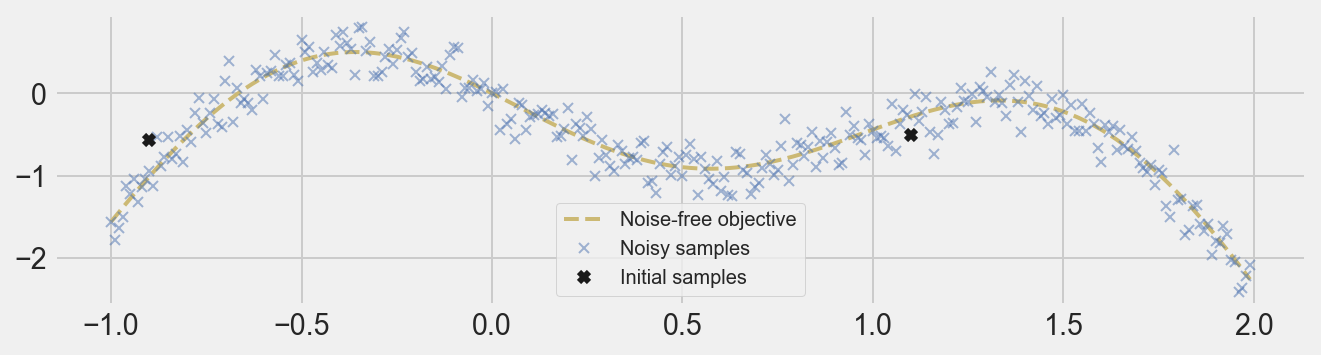

In [6]:
# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.5, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

**Goal:** find the global optimum in a small number of steps.

## Gaussian Process (GP)

With a GP, we can evaluate that function at test points, and they will have an uncertainty.

In [7]:
# RBF Kernel
# The Matern kernel is a generalization of the RBF, and it tends to work better.
def exponential_cov(x, y, params):
    return params[0]**2 * np.exp(-np.subtract.outer(x, y)**2 / (2*params[1]**2))

class GP:
    def __init__(self, kernel, params):
        self.x = None
        self.y = None
        self.kernel = kernel
        self.params = params
        pass
    
    def fit(self, x, y):
        self.x = x
        self.y = y
        return 
    
    def predict(self, x_new, return_std=False):
        # Computes the posterior mean and variance
        k = self.kernel(self.x, self.x, self.params)
        k_s = self.kernel(self.x, x_new, self.params)
        k_ss = self.kernel(x_new, x_new, self.params)
        post_mean = (k_s.T).dot(np.linalg.pinv(k)).dot(self.y)
        post_variance = k_ss - (k_s.T).dot(np.linalg.pinv(k)).dot(k_s)
        
        if return_std:
            return post_mean, post_variance
        return post_mean

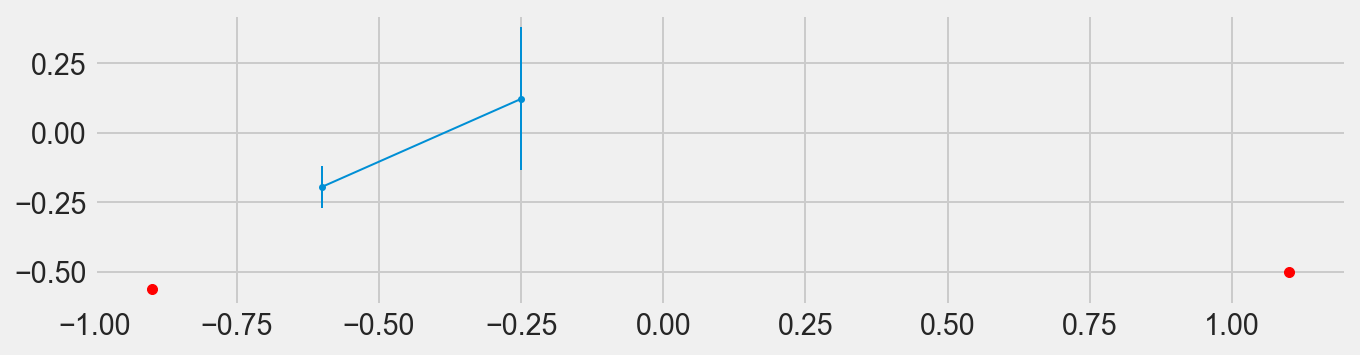

In [8]:
X_test = [-0.6, -0.25]

gp = GP(exponential_cov, params=[1, 1])
gp.fit(X_init, Y_init)
mean, variance = gp.predict(X_test, return_std=True)

Y_test = np.random.multivariate_normal(mean, variance)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(X_test, Y_test, yerr=variance.diagonal(), capsize=0)
ax.scatter(X_init, Y_init, c='red');

**The points closer to the initial points will have less uncertainty.**

BO will evaluare new points and act according to their uncertainty.

## Blackbox functions

As always, in ML, the **objective function** $f(x)$ is a **black box function**.

We do not have an **analytical expression** for $f$ nor do we know its **derivatives** (unless the objective function is the SSE as in gradient descent).

The evaluation of the function is restricted to **sampling at a point x** and getting a possibly **noisy response**.

## Function Expensive to Evaluate

This is the domain where Bayesian optimization techniques are most useful.

These are examples where the function to optimize is expensive to evaluate:

- Tuning hyperparameters of a deep neural network
- Probing drilling for oil at given geographic coordinates
- Evaluating the effectiveness of a drug

## Bayesian Optimization

It incorporates **prior** belief about $f$ and updates the prior with samples drawn from $f$ to get a **posterior** that better approximates $f$. 

- **Surrogate model:** model used for approximating the objective function.

- **Acquisition function:** Function that directs sampling to areas where an improvement over the current best observation is likely.

## Surrogate model $\hat{f}$

- It should be approximately equal to the original function.
- It is the **OBJECTIVE FUNCTION**
- It should be cheap to evaluate.
- It should approximate complex functions: The it should be a Non-parametric model.

Most populat surrogate model: Gaussian process (GP).

## Acquisition function $u(x)$

- This function proposes **sampling points** in the search space.
- It trades off exploitation and exploration.
- It should estimate the profit of optimizing the sampling point $x$ (TODO)
- It uses the surrogate model

The goal is to maximize the acquisition function to determine the next sampling point. (TODO)

## Exploration & Exploitation

#### Exploration

Sampling (or search) at locations **where the prediction uncertainty is high**.

#### Exploitation

Sampling (or search) where the surrogate model predicts a high objective.

## Bayesian Optimization Algorithm

In BO, we compute a **posterior distribution** by using a Gaussian process, which is called inside an **acquisition function**, and it is used to decide where to sample next.

Supposing you are trying to maximize a function $f$.

- Start with a few points.
- While it doesn't converge:
    1.	Train a **Gaussian Process** (surrogate model)
    2.	Find the maximum of the **acquisition function** $u(x)$ by using e.g. gradient ascent (or another method)
    3.	Evaluate the function at maximum of $u(x)$ (**new point sampled from the posterior**)

## Sampling a new point

The objective function $f$ will be sampled at

$$\mathbf{x}_t = \operatorname{argmax}_{\mathbf{x}} u(\mathbf{x} \lvert \mathcal{D}_{1:t-1})$$

$u$ is the acquisition function  
$\mathcal{D}_{1:t-1} = \{(\mathbf{x}_1, y_1),...,(\mathbf{x}_{t-1}, y_{t-1})\}$ are the $t−1$ samples drawn from $f$ so far.

So the next point to be sample will depend on the **ACQUISITION FUNCTION**.

## Common Acquisition Functions

### a) Upper confidence bound (UCB) or  GP-UCB

$$
\mu(x)=\mathbb{E} \widehat{f}(x)+\eta \operatorname{Var}[\widehat{f}(x)]
$$

That way, one can sample values where there's high variance and where there's high mean or by varying $\eta$ **(this balances exploration and exploitation)**.

In [9]:
from scipy.stats import norm

def ucb(X, X_sample, Y_sample, surrogate, balance=0.8):
    mu, variance = surrogate.predict(X, return_std=True)
    return mu + balance * variance

# Initial samples
X_sample = X_init
Y_sample = Y_init

gp = GP(exponential_cov, params=[1, 1])
gp.fit(X_sample, Y_sample)

ucb(1, X_sample, Y_sample, surrogate=gp)

-0.508045435215417

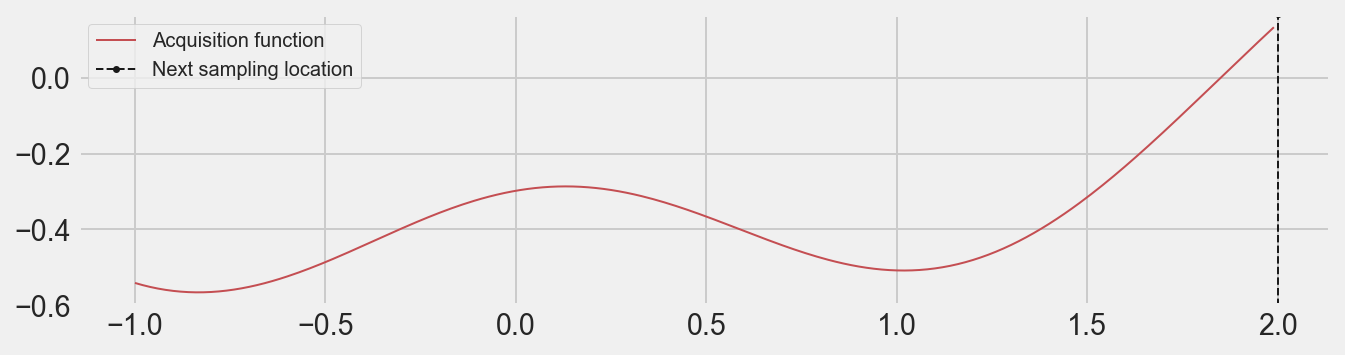

In [10]:
X_utility = np.arange(bounds[:, 0], bounds[:, 1], 0.01)
Y_utility = [ucb(X, X_sample, Y_sample, surrogate=gp) for X in X_utility]

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()    

plot_acquisition(X_utility, Y_utility, X_next=2.0, show_legend=True);

### b) Maximum probability of improvement (MPI)

Probability that the surrogate model evaluated at $x$ is greater than the current best value $f^*$.

$$
\mu(x)=P\left(\widehat{f}(x) \geq f^{*}+\epsilon\right)
$$

It can be computed analyically

$$
\mu(x) = \Phi\left(\frac{\mathbb{E} \widehat{f}(x)-f^{*}-\epsilon}{\operatorname{Var}[\widehat{f}(x)]}\right)
$$

where $\Phi$ is a cumulative distribution function.

In [11]:
def mpi(X, X_sample, Y_sample, surrogate, eps=0.1):
    mu, variance = surrogate.predict(X, return_std=True)
    mu_sample = surrogate.predict(X_sample)
    
    mu_sample_opt = np.max(mu_sample)

    return norm.cdf((mu - mu_sample_opt - eps)/variance)


mpi(1, X_sample, Y_sample, surrogate=gp)

8.186492887038388e-36

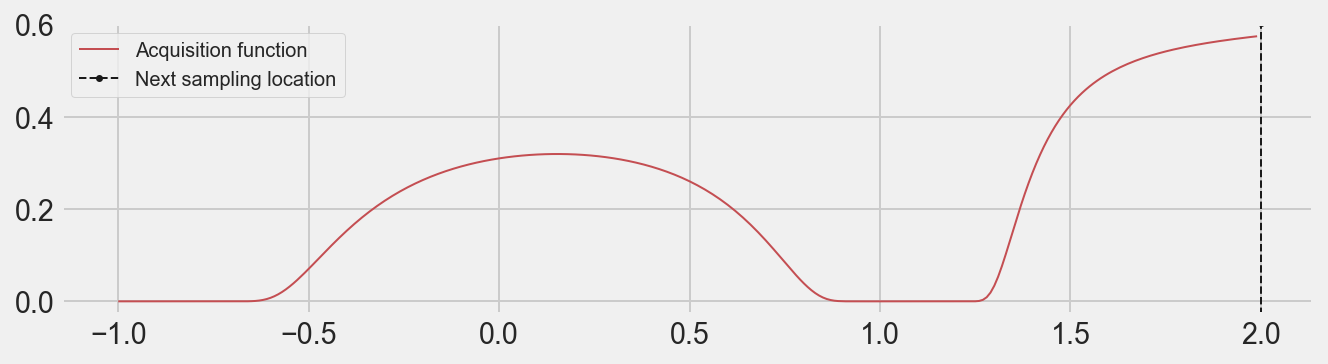

In [12]:
X_utility = np.arange(bounds[:, 0], bounds[:, 1], 0.01)
Y_utility = [mpi(X, X_sample, Y_sample, surrogate=gp) for X in X_utility]

plot_acquisition(X_utility, Y_utility, X_next=2.0, show_legend=True);

### c) Expected improvement (EI)

### Improvement 

If we measure a new point $x$ (for example, at time $n$), the improvement in the objective function will be:

$$I_n(x) = \max(f_{n}^{*} - f(x), 0)$$

$f_n^{*}$ = function evaluated at the best point point so far (at time $n$)

That can be also seen as:

$$I(x) = \max(f^{*} - Y, 0)$$

where $Y$ is a random variable $Y \sim \mathcal{N}\left(\mu, \sigma^{2}\right)$.

### Expected Improvement 

We are interested in the expected improvement:

$$
EI(x)=E_{Y \sim \mathcal{N}\left(\mu, \sigma^{2}\right)}[I(x)]
$$

$$EI(x) = \int_{-\infty}^{f^*} I(x) PDF(y) dy$$


With the reparameterization trick, $Y=\mu + \sigma \epsilon$ where $\epsilon\sim\mathcal{N}(0,1)$, we have:

$$
EI(x)=E_{\epsilon \sim \mathcal{N}(0,1)}[I(x)]
$$

That gives an analytical solution

$$EI(x) = \int_{-\infty}^{\infty} I(x) \phi(\epsilon) d\epsilon$$

$$
E I(x)=\int_{-\infty}^{\left(f^{*}-\mu\right) / \sigma}\left(f^{*}-\mu-\sigma \epsilon\right) \phi(\epsilon) d \epsilon
$$

$$
\begin{array}{c}{E I(x)=\left(f^{*}-\mu\right) \Phi\left(\frac{f^{*}-\mu}{\sigma}\right)-\sigma \int_{-\infty}^{\left(f^{*}-\mu\right) / \sigma} \epsilon \phi(\epsilon) d \epsilon} \\ {E I(x)=\left(f^{*}-\mu\right) \Phi\left(\frac{f^{*}-\mu}{\sigma}\right)+\frac{\sigma}{\sqrt{2 \pi}} \int_{-\infty}^{\left(f^{*}-\mu\right) / \sigma}(-\epsilon) e^{-\epsilon^{2} / 2} d \epsilon} \\ {E I(x)=\left(f^{*}-\mu\right) \Phi\left(\frac{f^{*}-\mu}{\sigma}\right)+\sigma\left(\phi\left(\frac{f^{*}-\mu}{\sigma}\right)-0\right)} \\ {E I(x)=\left(f^{*}-\mu\right) \Phi\left(\frac{f^{*}-\mu}{\sigma}\right)+\sigma \phi\left(\frac{f^{*}-\mu}{\sigma}\right)} \\ {E I(x)=\left(f^{*}-\mu\right) \Phi\left(\frac{f^{*}-\mu}{\sigma}\right)+\sigma \phi\left(\frac{f^{*}-\mu}{\sigma}\right)}\end{array}
$$

In [13]:
def expected_improvement(X, X_sample, Y_sample, surrogate):
    ''' Computes the EI at points X based on existing samples 
    X_sample and Y_sample using a Gaussian process surrogate model. 
    Args:
        X: Points at which EI shall be computed
        X_sample: Sample locations
        Y_sample: Sample values
        surrogate: Usually a GP
    Returns
        Expected improvements at points X '''
    
    mu, variance = surrogate.predict(X, return_std=True)
    mu_sample = surrogate.predict(X_sample)
    
    mu_sample_opt = np.max(mu_sample)

    Z = (mu_sample_opt - mu) / variance
    ei = (mu_sample_opt - mu) * norm.cdf(Z) + variance * norm.pdf(Z)

    return ei

expected_improvement(1, X_sample, Y_sample, surrogate=gp)

0.012838223198098058

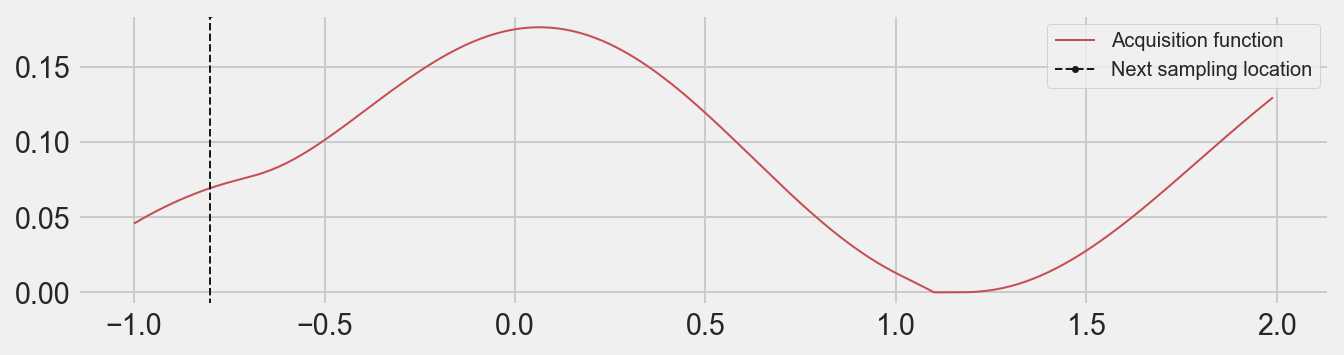

In [14]:
X_utility = np.arange(bounds[:, 0], bounds[:, 1], 0.01)
Y_utility = [expected_improvement(X, X_sample, Y_sample, surrogate=gp) for X in X_utility]  

plot_acquisition(X_utility, Y_utility, X_next=-0.8, show_legend=True);

That is the first acquisition function $u(x)$ that has to be maximized.

Ant the next point to be evaluated should be $x = 2.0$

## Bayesian Optimization Implementation

In [20]:
gp = GP(exponential_cov, params=[1, 0.2])

def min_obj(X):
    # Minimization objective is the negative acquisition function
    return -ucb(X, X_sample, Y_sample, surrogate=gp)

In [16]:
from scipy.optimize import minimize

# number of iterations
# In each iteration create a new sample 
n_iter = 8

# Initial samples
X_sample = X_init
Y_sample = Y_init

for i in range(n_iter):

    gp.fit(X_sample, Y_sample)
    
    # Maximize and obtain next sampling point from the acquisition function (expected_improvement)
    x0 = np.random.uniform(bounds[:, 0], bounds[:, 1])
    X_next = minimize(min_obj, x0=x0, bounds=bounds).x[0]

    # Obtain next sample from the objective function
    Y_next = f(X_next)
    print("x = {}, y = {}".format(X_next, Y_next))
    
    # Add sample to previous samples
    X_sample = np.append(X_sample, X_next)
    Y_sample = np.append(Y_sample, Y_next)
    

x = 2.0, y = -2.573336740330632
x = 0.1057987518347541, y = -0.040298838074998455
x = 0.549414273159323, y = -0.9517258550750505
x = 0.8516818578056763, y = -0.6489560844814426
x = 0.24629031603080762, y = -0.4673588415394202
x = -0.29046730398992215, y = 0.5287803398814388
x = 1.4784147064415178, y = -0.09608134231309345
x = 1.3422966890064119, y = -0.07408014180532199


## Plotting

In [17]:
def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu_variance = np.array([list(gpr.predict(x, return_std=True)) for x in X])
    mu, variance = mu_variance[:,0], mu_variance[:,1]
    plt.fill_between(X, 
                     mu + 1.96 * variance, 
                     mu - 1.96 * variance, 
                     alpha=0.1) 
    plt.plot(X, Y, 'r', lw=1, label='Noise-free objective')
    plt.plot(X, mu, 'b', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()    
        
def plot_convergence(X_sample, Y_sample, n_init=2):
    plt.figure(figsize=(12, 3))

    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x)+1)
    
    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    y_max_watermark = np.maximum.accumulate(y)
    
    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, 'bo-')
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Distance between consecutive x\'s')

    plt.subplot(1, 2, 2)
    plt.plot(r, y_max_watermark, 'ro-')
    plt.xlabel('Iteration')
    plt.ylabel('Best Y')
    plt.title('Value of best selected sample')

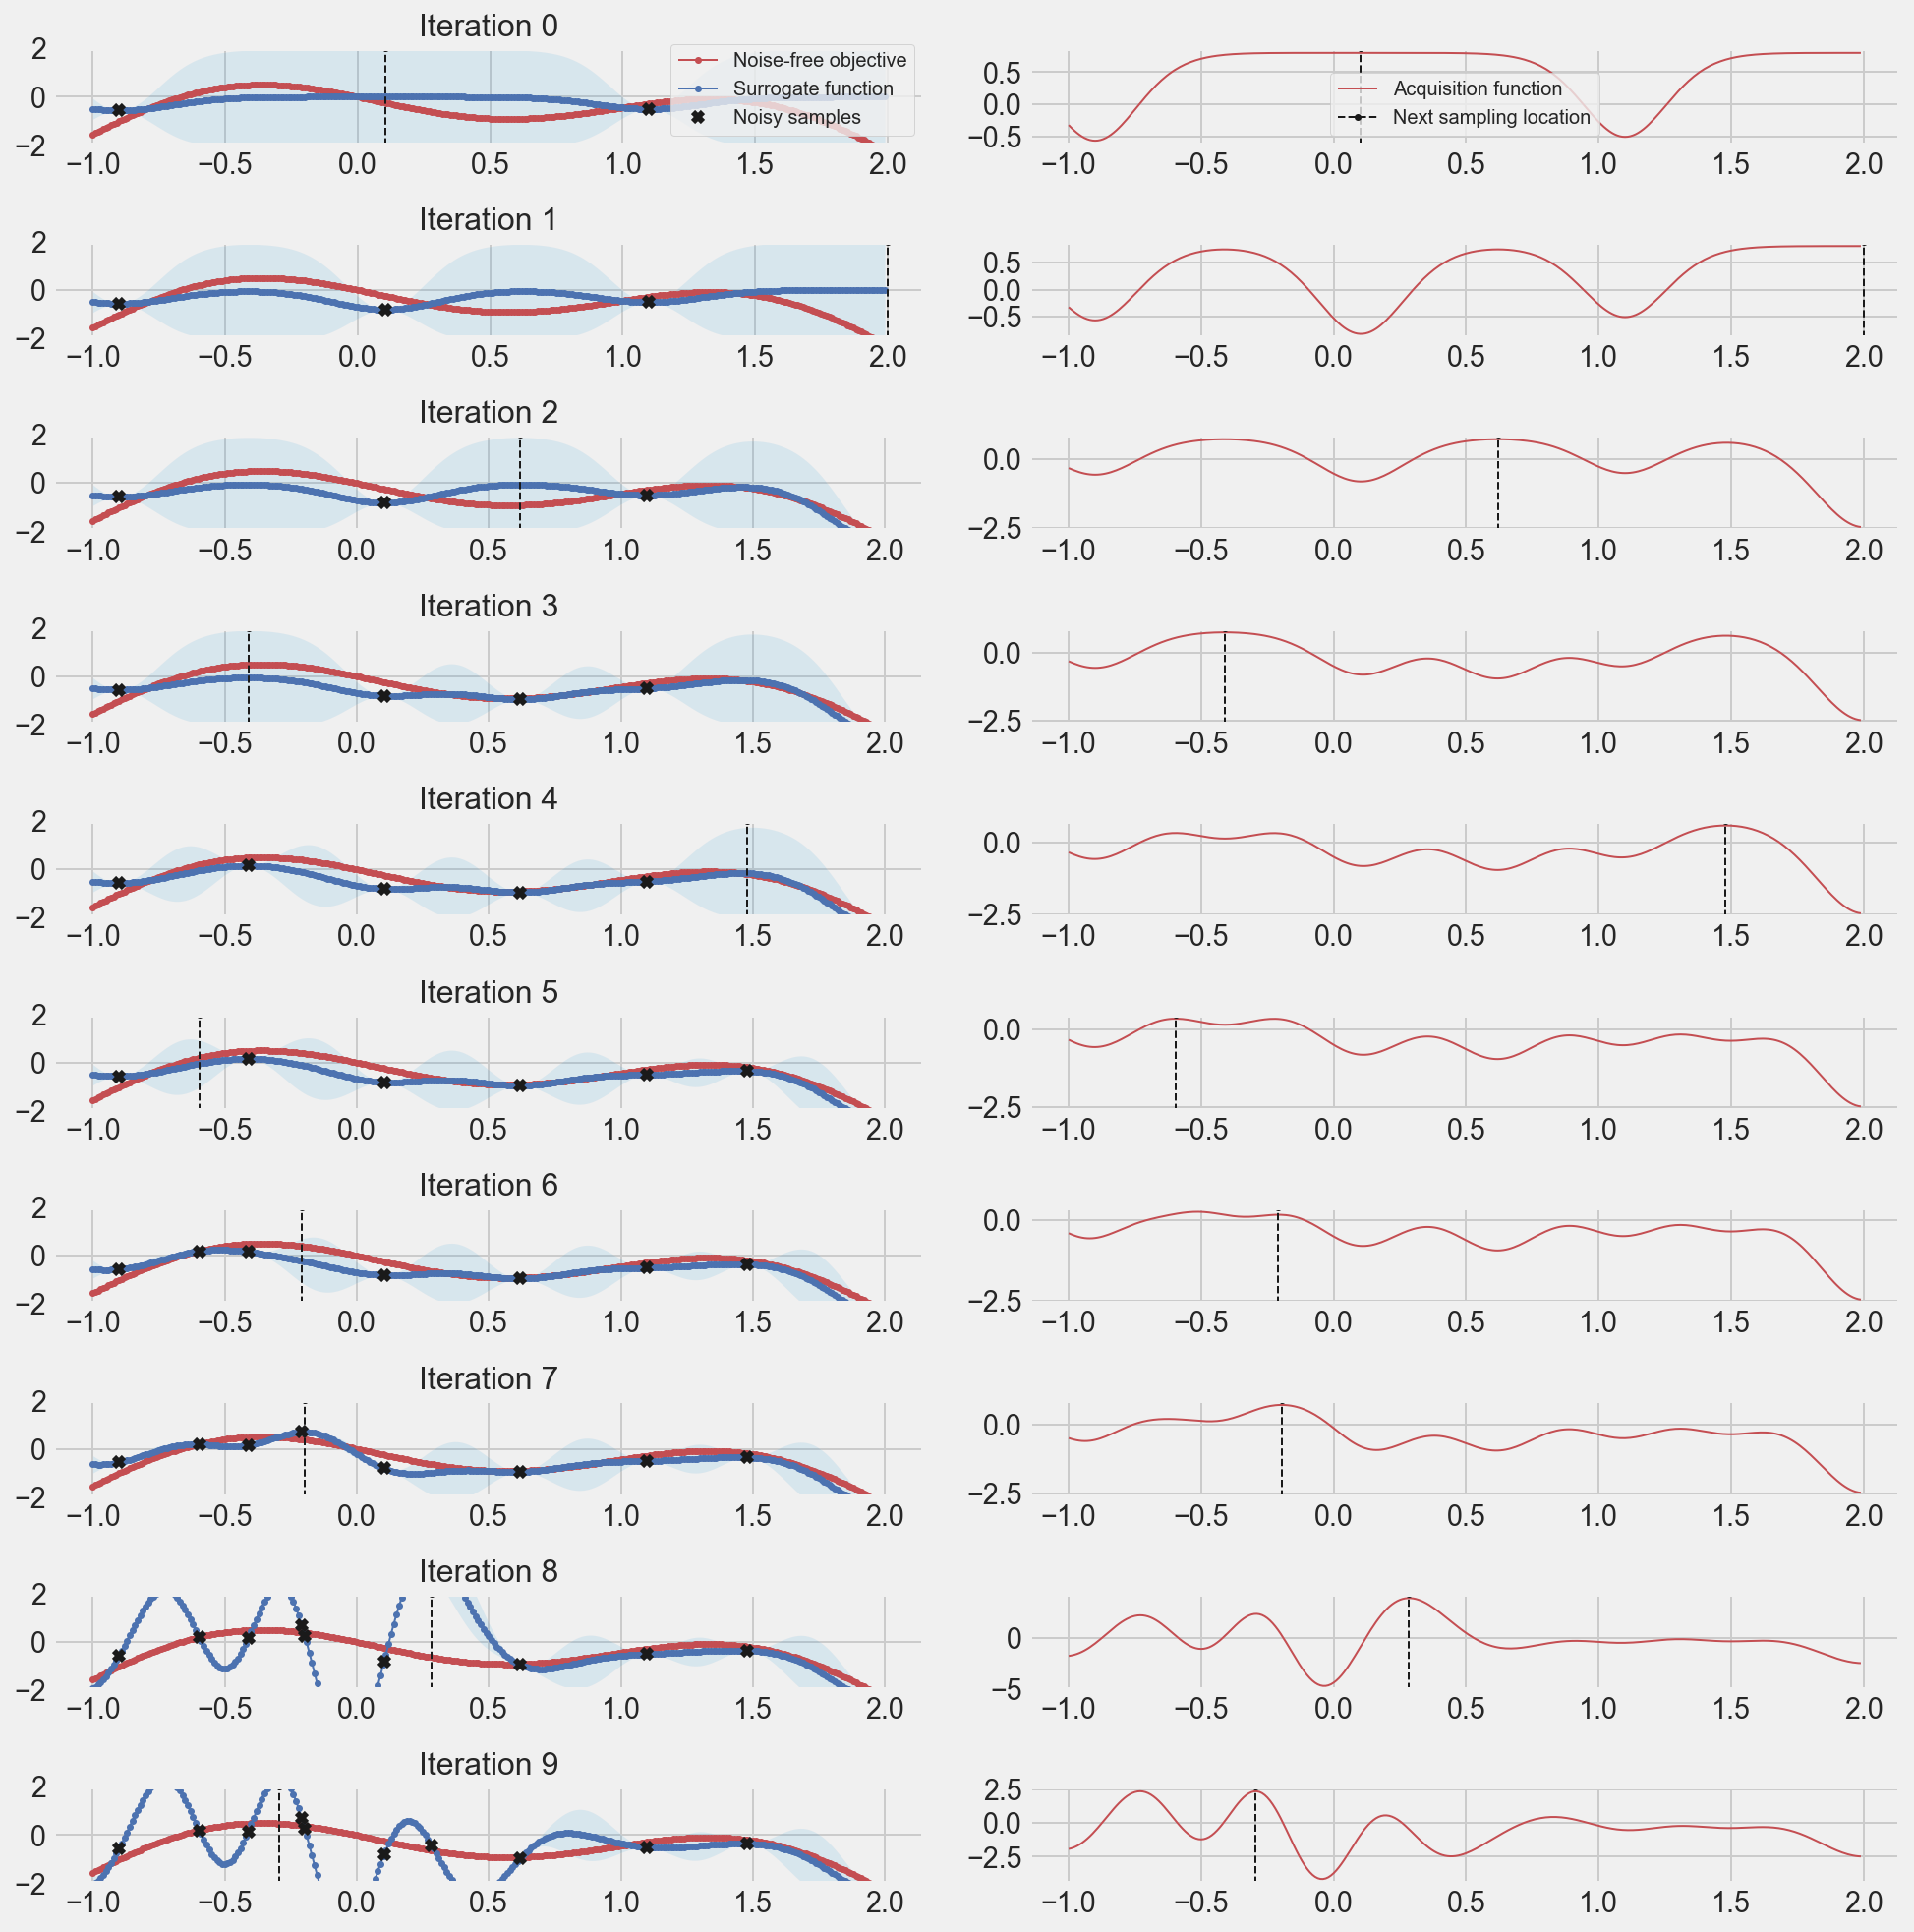

In [18]:
plt.figure(figsize=(15, n_iter * 2))
plt.subplots_adjust(hspace=1, wspace=0.12)

n_iter = 10

 # Initial samples
X_sample = X_init
Y_sample = Y_init

for i in range(n_iter):

    gp.fit(X_sample, Y_sample)
    
    min_val = 1
    ## GLOBAL OPTIMIZATION
    # - NLOPT
    # - CMA-ES = not much tuning
    # libcmaes
    # simulated annealing - to tune
    #
    # Maximize and obtain next sampling point from the acquisition function (expected_improvement)
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=10):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x
    X_next = min_x
            
#     x0 = np.random.uniform(bounds[:, 0], bounds[:, 1])
#     X_next = minimize(min_obj, x0=x0, bounds=bounds).x[0]

    # Obtain next sample from the objective function
    Y_next = f(X_next)
    
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gp, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i}')
    plt.ylim(-2, 2)

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, [ucb(x, X_sample, Y_sample, gp) for x in X], X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.append(X_sample, X_next)
    Y_sample = np.append(Y_sample, Y_next)

## Convergence Plot

A convergence plot reveals how many iterations are needed the find a maximum and if the sampling point proposals stay around that maximum i.e. converge to small proposal differences between consecutive steps.

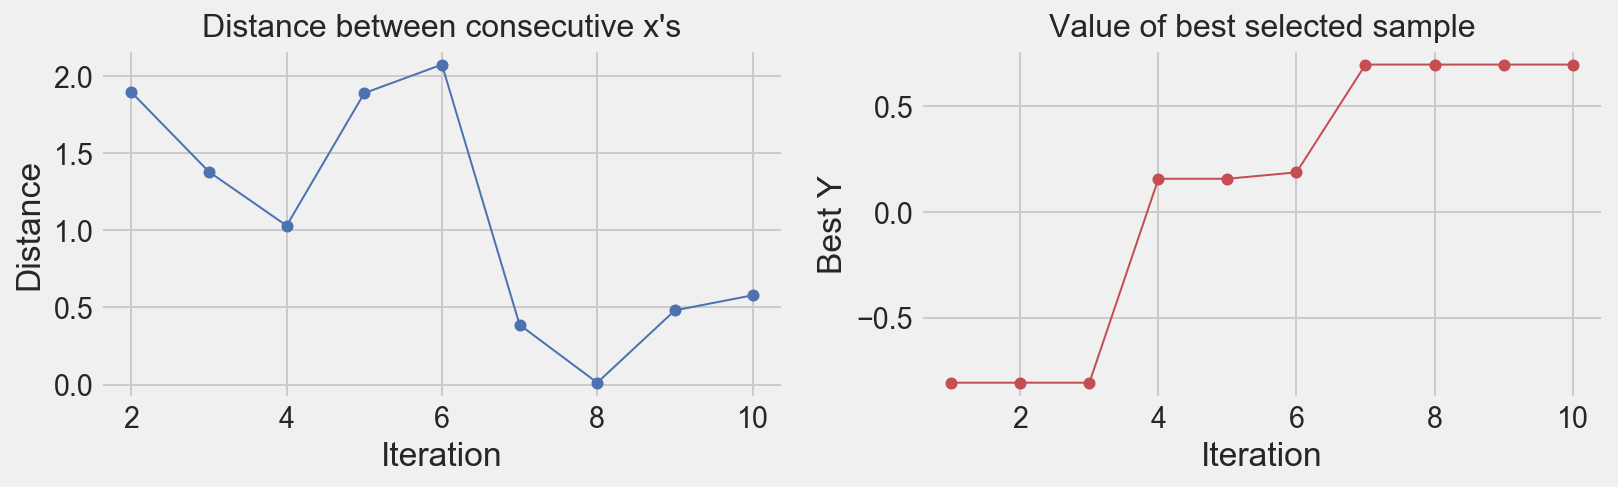

In [19]:
plot_convergence(X_sample, Y_sample)